In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
data_ = pd.read_csv('tashdata.csv')
data_.head()
mod_data = data_[['y_analysisGender2Category', 'y_analysisGender3Category']].rename(columns=
                {'y_analysisGender2Category':'Gender2', 'y_analysisGender3Category':'Gender3'})

mod_data.head()

,Gender2,Gender3
0,Feminine,Feminine
1,Feminine,Feminine
2,Masculine,Masculine
3,Masculine,Masculine
4,Masculine,Masculine


In [4]:
data_.columns

Index(['y_analysisGender2Category', 'y_analysisGender3Category',
       'analysisHasSecondaryMorphYN', 'analysisMutability',
       'm_analysisPluralPattern', 'm_analysisRAugVowel',
       'analysisSemanticCoreYN', 'analysisSingularTheme', 'p_analysisThemeCV',
       'p_analysisThemeFinalSegment', 'p_analysisThemeInitialSegment',
       's_lexiconAnimateYN', 'lexiconGlossEnglish', 'lexiconGlossFrench',
       's_lexiconHumanYN', 'm_lexiconLoanwordSource', 's_lexiconSemanticField',
       's_lexiconSexGender', 'recordID', 'm_wordDerivedCategory',
       'wordLexBitVector', 'm_wordNumSemanticCategory'],
      dtype='object')

In [6]:
for col in data_.columns:
    print(col)
    print(data_[col].value_counts())

y_analysisGender2Category
Masculine    1431
Feminine      483
Name: y_analysisGender2Category, dtype: int64
y_analysisGender3Category
Masculine    1116
Feminine      483
Neutral       315
Name: y_analysisGender3Category, dtype: int64
analysisHasSecondaryMorphYN
Yes    414
Name: analysisHasSecondaryMorphYN, dtype: int64
analysisMutability
Fixed-Masc       762
Fixed-Fem        423
Variable-Masc    354
Neutral          315
Variable-Fem      60
Name: analysisMutability, dtype: int64
m_analysisPluralPattern
No Plural      640
External       501
Internal       379
Mixed          306
Only Plural     50
id Plural       38
Name: m_analysisPluralPattern, dtype: int64
m_analysisRAugVowel
A       1044
Zero     698
I        172
Name: m_analysisRAugVowel, dtype: int64
analysisSemanticCoreYN
N    1564
Y     350
Name: analysisSemanticCoreYN, dtype: int64
analysisSingularTheme
glaj      3
ssgni     3
gri       3
frdi      2
!sjjad    2
         ..
mχlaw     1
!gʷdi     1
mzil      1
!anud     1
knjaw  

In [8]:
def check(string, pos):
    if string[pos]=='C':
        return 1
    else:
        return 0
CV_theme = data_['p_analysisThemeCV']
#mod_data['length'] = CV_theme.map(lambda x: len(str(x)))
mod_data['CountC'] = CV_theme.map(lambda x: str(x).count('C'))
mod_data['CountV'] = CV_theme.map(lambda x: str(x).count('V'))
mod_data['Start']  = CV_theme.map(lambda x: check(str(x), 0))
mod_data['End']  = CV_theme.map(lambda x: check(str(x), -1))
mod_data['start_letter'] = data_['p_analysisThemeInitialSegment']
mod_data['end_letter'] = data_['p_analysisThemeFinalSegment']
#mod_data['Cat_theme'] = data_['s_lexiconSemanticField']

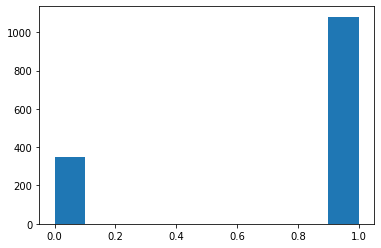

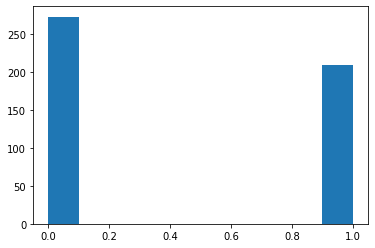

In [39]:
for gender in ['Masculine', 'Feminine']:
    mod_data_frag = mod_data[mod_data['Gender2']==gender]
    plt.hist(mod_data_frag['End'])
    plt.show()

In [9]:
mod_data.head()

,Gender2,Gender3,CountC,CountV,Start,End,start_letter,end_letter
0,Feminine,Feminine,5,0,1,1,l,z
1,Feminine,Feminine,4,1,1,0,l,a
2,Masculine,Masculine,5,1,1,1,l,n
3,Masculine,Masculine,3,1,1,1,l,m
4,Masculine,Masculine,4,2,1,1,d,k


# Building Some Simple Classification Model Using the above features

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import *

In [22]:
le = LabelEncoder()
le1 = LabelEncoder()
target = mod_data['Gender2']
target = le.fit_transform(target)
mod_data[mod_data.columns[-2]] = le1.fit_transform(mod_data[mod_data.columns[-2]])
mod_data[mod_data.columns[-1]] = le1.fit_transform(mod_data[mod_data.columns[-1]])
features = np.array(mod_data[mod_data.columns[2:]])
train_feat, test_feat, train_targ, test_tar = train_test_split(features, target, test_size=0.20, random_state=1)
rf = RandomForestClassifier(n_estimators=500, random_state=10, max_depth=10)
rf.fit(train_feat, train_targ)

RandomForestClassifier(max_depth=10, n_estimators=500, random_state=10)

In [23]:
predictions = rf.predict(test_feat)
print(f"Accuracy:{accuracy_score(predictions, test_tar)}, Precision:{precision_score(predictions, test_tar)}")
print(f"Recall:{recall_score(predictions, test_tar)}, F1-score: {f1_score(predictions, test_tar)}")


Accuracy:0.7989556135770235, Precision:0.931740614334471
Recall:0.8272727272727273, F1-score: 0.8764044943820225


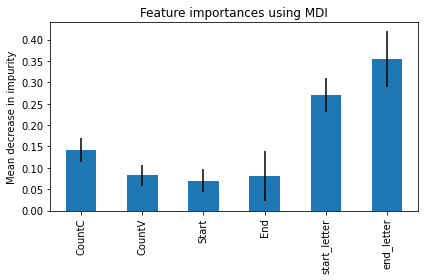

In [24]:
#Biased Importance
vals = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(vals, index=mod_data.columns[2:])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()


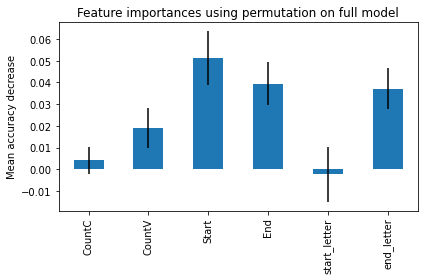

In [26]:
# Unbiased 
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, test_feat, test_tar, n_repeats=10, random_state=45, n_jobs=2
)
#print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=mod_data.columns[2:])
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [11]:
for theme in ['CCCVC', 'CCVC', 'CCCV', 'CVCVC', 'VCCVC']:
    print(theme)
    data_frag = data_[data_['p_analysisThemeCV']==theme]
    print(data_frag['y_analysisGender2Category'].value_counts())

CCCVC
Masculine    312
Feminine      42
Name: y_analysisGender2Category, dtype: int64
CCVC
Masculine    164
Feminine      30
Name: y_analysisGender2Category, dtype: int64
CCCV
Masculine    80
Feminine     40
Name: y_analysisGender2Category, dtype: int64
CVCVC
Masculine    73
Feminine     10
Name: y_analysisGender2Category, dtype: int64
VCCVC
Masculine    56
Feminine     24
Name: y_analysisGender2Category, dtype: int64


In [8]:
data_frag = data_[data_['p_analysisThemeCV']=='CCVC']
data_frag['y_analysisGender2Category'].value_counts()

Masculine    164
Feminine      30
Name: y_analysisGender2Category, dtype: int64

In [9]:
data_frag = data_[data_['p_analysisThemeCV']=='CCCV']
data_frag['y_analysisGender2Category'].value_counts()

Masculine    80
Feminine     40
Name: y_analysisGender2Category, dtype: int64